# Series tests: load saved CNN / QNN / Hybrid weights and predict

This notebook reloads the trained models from `artifacts/` and runs them on a few SMILES series (alcohol chain, aromatic substitutions, relative baselines, and the earlier stress test). Each model gets its own cell, and the last cell shows a side-by-side comparison.

In [20]:
from pathlib import Path
import json
import sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import pennylane as qml
from rdkit import Chem
from rdkit.Chem import Descriptors

# Local imports
PROJECT_ROOT = Path('..').resolve()
ARTIFACTS = PROJECT_ROOT / 'artifacts'
RESULTS = PROJECT_ROOT / 'results'
sys.path.append(str((PROJECT_ROOT / 'src').resolve()))
from cnn_utils import SmilesCNN, encode_smiles  # noqa: E402
from chem_utils import load_aqsoldb, canonicalize_and_clean  # noqa: E402

MAX_LEN = 256  # same as training
DESC_COLS = [
    "MolWt",
    "MolLogP",
    "TPSA",
    "NumHDonors",
    "NumHAcceptors",
    "NumRotatableBonds",
    "NumAromaticRings",
    "RingCount",
]
NQ = len(DESC_COLS)

# Load vocab and descriptor scaler
with open(ARTIFACTS / "vocab.json") as f:
    vocab = json.load(f)
stoi = {tok: idx for idx, tok in enumerate(vocab)}

scaler_npz = np.load(ARTIFACTS / "descriptor_scaler.npz")
scaler_mean = scaler_npz["mean"]
scaler_scale = scaler_npz["scale"]

def scale_descriptors(arr: np.ndarray) -> np.ndarray:
    return (arr - scaler_mean) / scaler_scale

def smiles_to_descriptors(smiles: str) -> np.ndarray | None:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return np.array(
        [
            Descriptors.MolWt(mol),
            Descriptors.MolLogP(mol),
            Descriptors.TPSA(mol),
            Descriptors.NumHDonors(mol),
            Descriptors.NumHAcceptors(mol),
            Descriptors.NumRotatableBonds(mol),
            Descriptors.NumAromaticRings(mol),
            Descriptors.RingCount(mol),
        ],
        dtype=np.float32,
    )

def prepare_descriptor_matrix(df: pd.DataFrame) -> tuple[pd.DataFrame, np.ndarray]:
    feats = []
    keep_rows = []
    for idx, row in df.iterrows():
        desc = smiles_to_descriptors(row["smiles"])
        if desc is None:
            print(f"Skipping invalid SMILES at row {idx}: {row['smiles']}")
            keep_rows.append(False)
        else:
            feats.append(desc)
            keep_rows.append(True)
    clean = df[keep_rows].reset_index(drop=True)
    return clean, np.vstack(feats)

def build_series(rows):
    return pd.DataFrame(rows, columns=["compound", "smiles", "expectation"])

# Series definitions
series_groups: dict[str, pd.DataFrame] = {
    "alcohol_chain": build_series(
        [
            ("Methanol", "CO", ""),
            ("Ethanol", "CCO", ""),
            ("Propanol", "CCCO", ""),
            ("Butanol", "CCCCO", ""),
            ("Pentanol", "CCCCCO", ""),
            ("Hexanol", "CCCCCCO", ""),
            ("Heptanol", "CCCCCCCO", ""),
            ("Octanol", "CCCCCCCCO", ""),
            ("Nonanol", "CCCCCCCCCO", ""),
            ("Decanol", "CCCCCCCCCCO", ""),
        ]
    ),
    "aromatic_subs": build_series(
        [
            ("Phenol", "c1ccccc1O", "higher"),
            ("Hydroquinone", "c1cc(ccc1O)O", "higher"),
            ("Aniline", "c1ccccc1N", "higher"),
            ("Nitrobenzene", "c1ccccc1[N+](=O)[O-]", "higher"),
            ("Benzaldehyde", "O=CC1=CC=CC=C1", "higher"),
            ("Benzene", "c1ccccc1", "lower"),
            ("Toluene", "Cc1ccccc1", "lower"),
            ("Chlorobenzene", "c1ccccc1Cl", "lower"),
            ("Bromobenzene", "c1ccccc1Br", "lower"),
            ("Acetophenone", "CC(=O)c1ccccc1", "lower"),
        ]
    ),
    "relative_baseline": build_series(
        [
            ("Hexane", "CCCCCC", "low"),
            ("Methanol", "CO", "high"),
            ("Phenol", "c1cc(ccc1)O", "high"),
            ("Decanol", "CCCCCCCCCCO", "low"),
            ("Hydroquinone", "c1cc(ccc1O)O", "high"),
        ]
    ),
    "stress_test": build_series(
        [
            ("Ethyl acetate", "CCOC(=O)C", ""),
            ("Butanol", "CCCCO", ""),
            ("Acetophenone", "CC(=O)c1ccccc1", ""),
            ("Glycerol", "C(C(CO)O)O", ""),
            ("Isobutanol", "CC(C)CO", ""),
        ]
    ),
}

# Attach ground truth from AqSolDB when available
aqsoldb = canonicalize_and_clean(load_aqsoldb(PROJECT_ROOT / "data" / "aqsoldb.csv"))
aqsoldb_map = aqsoldb.set_index("SMILES")["Solubility"].to_dict()

def attach_truth(df: pd.DataFrame) -> pd.DataFrame:
    y_true = []
    for smi in df["smiles"]:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            y_true.append(np.nan)
            continue
        can = Chem.MolToSmiles(mol)
        y_true.append(aqsoldb_map.get(can, np.nan))
    out = df.copy()
    out["y_true"] = y_true
    return out

series_groups = {k: attach_truth(v) for k, v in series_groups.items()}

series_groups


[00:45:04] WARNING: not removing hydrogen atom without neighbors
[00:45:04] WARNING: not removing hydrogen atom without neighbors
[00:45:04] WARNING: not removing hydrogen atom without neighbors
[00:45:04] WARNING: not removing hydrogen atom without neighbors
[00:45:04] WARNING: not removing hydrogen atom without neighbors
[00:45:05] WARNING: not removing hydrogen atom without neighbors
[00:45:05] WARNING: not removing hydrogen atom without neighbors
[00:45:05] WARNING: not removing hydrogen atom without neighbors
[00:45:05] WARNING: not removing hydrogen atom without neighbors
[00:45:05] WARNING: not removing hydrogen atom without neighbors
[00:45:05] WARNING: not removing hydrogen atom without neighbors
[00:45:05] WARNING: not removing hydrogen atom without neighbors
[00:45:05] WARNING: not removing hydrogen atom without neighbors
[00:45:05] WARNING: not removing hydrogen atom without neighbors
[00:45:05] WARNING: not removing hydrogen atom without neighbors
[00:45:05] WARNING: not r

{'alcohol_chain':    compound       smiles expectation    y_true
 0  Methanol           CO              1.494280
 1   Ethanol          CCO              1.233668
 2  Propanol         CCCO              0.620000
 3   Butanol        CCCCO             -0.050409
 4  Pentanol       CCCCCO             -0.602800
 5   Hexanol      CCCCCCO             -1.382910
 6  Heptanol     CCCCCCCO             -1.842500
 7   Octanol    CCCCCCCCO             -2.637593
 8   Nonanol   CCCCCCCCCO             -3.013012
 9   Decanol  CCCCCCCCCCO             -3.631238,
 'aromatic_subs':         compound                smiles expectation    y_true
 0         Phenol             c1ccccc1O      higher -0.040000
 1   Hydroquinone          c1cc(ccc1O)O      higher -0.196737
 2        Aniline             c1ccccc1N      higher -0.425017
 3   Nitrobenzene  c1ccccc1[N+](=O)[O-]      higher -1.800000
 4   Benzaldehyde        O=CC1=CC=CC=C1      higher -1.209572
 5        Benzene              c1ccccc1       lower -1.642309
 6 

In [21]:
# CNN predictions
cnn_model = SmilesCNN(vocab_size=len(vocab), max_len=MAX_LEN, dropout=0.002)
cnn_model.load_state_dict(torch.load(ARTIFACTS / "cnn_weights.pt", map_location="cpu"))
cnn_model.eval()

def predict_cnn(df: pd.DataFrame) -> pd.DataFrame:
    enc = np.stack([encode_smiles(s, stoi, MAX_LEN) for s in df["smiles"]])
    with torch.no_grad():
        preds = cnn_model(torch.tensor(enc)).numpy()
    out = df.copy()
    out["y_pred"] = preds
    return out

cnn_results = {name: predict_cnn(df) for name, df in series_groups.items()}
cnn_results

{'alcohol_chain':    compound       smiles expectation    y_true    y_pred
 0  Methanol           CO              1.494280  0.726972
 1   Ethanol          CCO              1.233668  0.773798
 2  Propanol         CCCO              0.620000  0.777434
 3   Butanol        CCCCO             -0.050409  0.373222
 4  Pentanol       CCCCCO             -0.602800 -0.007508
 5   Hexanol      CCCCCCO             -1.382910 -1.419102
 6  Heptanol     CCCCCCCO             -1.842500 -3.486497
 7   Octanol    CCCCCCCCO             -2.637593 -3.486497
 8   Nonanol   CCCCCCCCCO             -3.013012 -3.486497
 9   Decanol  CCCCCCCCCCO             -3.631238 -3.486497,
 'aromatic_subs':         compound                smiles expectation    y_true    y_pred
 0         Phenol             c1ccccc1O      higher -0.040000 -1.249777
 1   Hydroquinone          c1cc(ccc1O)O      higher -0.196737 -1.145922
 2        Aniline             c1ccccc1N      higher -0.425017 -0.918642
 3   Nitrobenzene  c1ccccc1[N+](=O)[O-]

In [22]:
# Pure QNN predictions
q_dev = qml.device("default.qubit", wires=NQ, shots=None)

def qnn_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(NQ), rotation="X")
    qml.StronglyEntanglingLayers(weights, wires=range(NQ))
    return [qml.expval(qml.PauliZ(i)) for i in range(NQ)]

q_weight_shapes = {"weights": (2, NQ, 3)}
q_qnode = qml.QNode(qnn_circuit, q_dev, interface="torch", diff_method="backprop")

class PureQNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.q_layer = qml.qnn.TorchLayer(q_qnode, q_weight_shapes)
        self.head = nn.Linear(NQ, 1)

    def forward(self, x):
        q_out = self.q_layer(x)
        return self.head(q_out).squeeze(-1)

qnn_model = PureQNN()
qnn_model.load_state_dict(torch.load(ARTIFACTS / "qnn_weights.pt", map_location="cpu"))
qnn_model.eval()

def predict_qnn(df: pd.DataFrame) -> pd.DataFrame:
    clean, feats = prepare_descriptor_matrix(df)
    X = torch.tensor(scale_descriptors(feats), dtype=torch.float32)
    with torch.no_grad():
        preds = qnn_model(X).numpy()
    out = clean.copy()
    out["y_pred"] = preds
    return out

qnn_results = {name: predict_qnn(df) for name, df in series_groups.items()}
qnn_results

{'alcohol_chain':    compound       smiles expectation    y_true    y_pred
 0  Methanol           CO              1.494280  0.457039
 1   Ethanol          CCO              1.233668  0.281399
 2  Propanol         CCCO              0.620000  0.101131
 3   Butanol        CCCCO             -0.050409 -0.158103
 4  Pentanol       CCCCCO             -0.602800 -0.492754
 5   Hexanol      CCCCCCO             -1.382910 -0.895793
 6  Heptanol     CCCCCCCO             -1.842500 -1.356906
 7   Octanol    CCCCCCCCO             -2.637593 -1.862970
 8   Nonanol   CCCCCCCCCO             -3.013012 -2.398793
 9   Decanol  CCCCCCCCCCO             -3.631238 -2.948031,
 'aromatic_subs':         compound                smiles expectation    y_true    y_pred
 0         Phenol             c1ccccc1O      higher -0.040000 -1.203784
 1   Hydroquinone          c1cc(ccc1O)O      higher -0.196737 -0.803896
 2        Aniline             c1ccccc1N      higher -0.425017 -1.158516
 3   Nitrobenzene  c1ccccc1[N+](=O)[O-]

In [23]:
# Hybrid predictions
h_dev = qml.device("default.qubit", wires=NQ, shots=None)

def hybrid_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(NQ), rotation="X")
    qml.StronglyEntanglingLayers(weights, wires=range(NQ))
    return [qml.expval(qml.PauliZ(i)) for i in range(NQ)]

hyb_weight_shapes = {"weights": (3, NQ, 3)}
h_qnode = qml.QNode(hybrid_circuit, h_dev, interface="torch", diff_method="backprop")

class HybridReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(NQ, NQ),
            nn.ReLU(),
            nn.Linear(NQ, NQ),
        )
        self.q_layer = qml.qnn.TorchLayer(h_qnode, hyb_weight_shapes)
        self.head = nn.Linear(NQ, 1)

    def forward(self, x):
        enc = self.encoder(x)
        q_out = self.q_layer(enc)
        return self.head(q_out).squeeze(-1)

hyb_model = HybridReg()
hyb_model.load_state_dict(torch.load(ARTIFACTS / "hybrid_weights.pt", map_location="cpu"))
hyb_model.eval()

def predict_hybrid(df: pd.DataFrame) -> pd.DataFrame:
    clean, feats = prepare_descriptor_matrix(df)
    X = torch.tensor(scale_descriptors(feats), dtype=torch.float32)
    with torch.no_grad():
        preds = hyb_model(X).numpy()
    out = clean.copy()
    out["y_pred"] = preds
    return out

hyb_results = {name: predict_hybrid(df) for name, df in series_groups.items()}
hyb_results

{'alcohol_chain':    compound       smiles expectation    y_true    y_pred
 0  Methanol           CO              1.494280  0.862819
 1   Ethanol          CCO              1.233668  0.878096
 2  Propanol         CCCO              0.620000  0.888533
 3   Butanol        CCCCO             -0.050409  0.565090
 4  Pentanol       CCCCCO             -0.602800  0.175825
 5   Hexanol      CCCCCCO             -1.382910 -0.271738
 6  Heptanol     CCCCCCCO             -1.842500 -0.767611
 7   Octanol    CCCCCCCCO             -2.637593 -1.299562
 8   Nonanol   CCCCCCCCCO             -3.013012 -1.853463
 9   Decanol  CCCCCCCCCCO             -3.631238 -2.413737,
 'aromatic_subs':         compound                smiles expectation    y_true    y_pred
 0         Phenol             c1ccccc1O      higher -0.040000 -0.236371
 1   Hydroquinone          c1cc(ccc1O)O      higher -0.196737 -0.630065
 2        Aniline             c1ccccc1N      higher -0.425017 -0.236009
 3   Nitrobenzene  c1ccccc1[N+](=O)[O-]

In [24]:
# Side-by-side comparison and optional export
all_model_results = {
    "cnn": cnn_results,
    "qnn": qnn_results,
    "hybrid": hyb_results,
}

combined: dict[str, pd.DataFrame] = {}
for name, base in series_groups.items():
        merged = base.copy()
        for model_name, res_map in all_model_results.items():
            merged = merged.merge(
                res_map[name][["compound", "y_pred"]],
                on="compound",
                how="left",
                suffixes=("", f"_{model_name}"),
            ).rename(columns={"y_pred": f"{model_name}_y_pred"})
        combined[name] = merged
        display(merged[[
            "compound",
            "smiles",
            "expectation",
            "y_true",
            "cnn_y_pred",
            "qnn_y_pred",
            "hybrid_y_pred",
        ]])

        merged.to_csv(RESULTS / f"series_test_{name}.csv", index=False)

combined


,compound,smiles,expectation,y_true,cnn_y_pred,qnn_y_pred,hybrid_y_pred
0,Methanol,CO,,1.494280,0.726972,0.457039,0.862819
1,Ethanol,CCO,,1.233668,0.773798,0.281399,0.878096
2,Propanol,CCCO,,0.620000,0.777434,0.101131,0.888533
3,Butanol,CCCCO,,-0.050409,0.373222,-0.158103,0.565090
4,Pentanol,CCCCCO,,-0.602800,-0.007508,-0.492754,0.175825
5,Hexanol,CCCCCCO,,-1.382910,-1.419102,-0.895793,-0.271738
6,Heptanol,CCCCCCCO,,-1.842500,-3.486497,-1.356906,-0.767611
7,Octanol,CCCCCCCCO,,-2.637593,-3.486497,-1.862970,-1.299562
8,Nonanol,CCCCCCCCCO,,-3.013012,-3.486497,-2.398793,-1.853463
9,Decanol,CCCCCCCCCCO,,-3.631238,-3.486497,-2.948031,-2.413737


,compound,smiles,expectation,y_true,cnn_y_pred,qnn_y_pred,hybrid_y_pred
0,Phenol,c1ccccc1O,higher,-0.040000,-1.249777,-1.203784,-0.236371
1,Hydroquinone,c1cc(ccc1O)O,higher,-0.196737,-1.145922,-0.803896,-0.630065
2,Aniline,c1ccccc1N,higher,-0.425017,-0.918642,-1.158516,-0.236009
3,Nitrobenzene,c1ccccc1[N+](=O)[O-],higher,-1.800000,-2.009950,-2.221515,-1.591717
4,Benzaldehyde,O=CC1=CC=CC=C1,higher,-1.209572,-0.917717,-1.950146,-1.074261
5,Benzene,c1ccccc1,lower,-1.642309,-1.769788,-2.375929,-1.092028
6,Toluene,Cc1ccccc1,lower,-2.206298,-2.080077,-2.666711,-1.629900
7,Chlorobenzene,c1ccccc1Cl,lower,-2.449320,-2.219820,-3.017039,-2.289722
8,Bromobenzene,c1ccccc1Br,lower,-2.568561,-2.759974,-3.290104,-2.709965
9,Acetophenone,CC(=O)c1ccccc1,lower,-1.280387,-1.147632,-2.320246,-1.694584


,compound,smiles,expectation,y_true,cnn_y_pred,qnn_y_pred,hybrid_y_pred
0,Hexane,CCCCCC,low,-3.944170,-4.398106,-2.918144,-2.147102
1,Methanol,CO,high,1.494280,0.726972,0.457039,0.862819
2,Phenol,c1cc(ccc1)O,high,-0.040000,-1.374971,-1.203784,-0.236371
3,Decanol,CCCCCCCCCCO,low,-3.631238,-3.486497,-2.948031,-2.413737
4,Hydroquinone,c1cc(ccc1O)O,high,-0.196737,-1.145922,-0.803896,-0.630065


,compound,smiles,expectation,y_true,cnn_y_pred,qnn_y_pred,hybrid_y_pred
0,Ethyl acetate,CCOC(=O)C,,-0.025404,0.176708,-0.888574,0.299531
1,Butanol,CCCCO,,-0.050409,0.373222,-0.158103,0.565090
2,Acetophenone,CC(=O)c1ccccc1,,-1.280387,-1.147632,-2.320246,-1.694584
3,Glycerol,C(C(CO)O)O,,1.035769,0.608277,-0.167154,1.111456
4,Isobutanol,CC(C)CO,,0.040000,0.464059,-0.082886,0.674432


{'alcohol_chain':    compound       smiles expectation    y_true  cnn_y_pred  qnn_y_pred  \
 0  Methanol           CO              1.494280    0.726972    0.457039   
 1   Ethanol          CCO              1.233668    0.773798    0.281399   
 2  Propanol         CCCO              0.620000    0.777434    0.101131   
 3   Butanol        CCCCO             -0.050409    0.373222   -0.158103   
 4  Pentanol       CCCCCO             -0.602800   -0.007508   -0.492754   
 5   Hexanol      CCCCCCO             -1.382910   -1.419102   -0.895793   
 6  Heptanol     CCCCCCCO             -1.842500   -3.486497   -1.356906   
 7   Octanol    CCCCCCCCO             -2.637593   -3.486497   -1.862970   
 8   Nonanol   CCCCCCCCCO             -3.013012   -3.486497   -2.398793   
 9   Decanol  CCCCCCCCCCO             -3.631238   -3.486497   -2.948031   
 
    hybrid_y_pred  
 0       0.862819  
 1       0.878096  
 2       0.888533  
 3       0.565090  
 4       0.175825  
 5      -0.271738  
 6      -0.76761

In [25]:
# Pairwise deltas and summary stats per series
pairwise = [("cnn", "qnn"), ("cnn", "hybrid"), ("qnn", "hybrid")]
diff_tables: dict[str, pd.DataFrame] = {}
summary_tables: dict[str, pd.DataFrame] = {}

for name, df in combined.items():
    work = df.copy()
    work["qnn_minus_cnn"] = work["qnn_y_pred"] - work["cnn_y_pred"]
    work["hybrid_minus_cnn"] = work["hybrid_y_pred"] - work["cnn_y_pred"]
    for a, b in pairwise:
        work[f"abs_{a}_{b}"] = (work[f"{a}_y_pred"] - work[f"{b}_y_pred"]).abs()
    diff_tables[name] = work
    summary_tables[name] = pd.DataFrame(
        [
            {
                "pair": f"{a}-{b}",
                "mean_abs_diff": work[f"abs_{a}_{b}"].mean(),
                "max_abs_diff": work[f"abs_{a}_{b}"].max(),
            }
            for a, b in pairwise
        ]
    )

for name in combined:
    print(f"=== {name} ===")
    cols = [
        "compound",
        "smiles",
        "expectation",
        "y_true",
        "cnn_y_pred",
        "qnn_y_pred",
        "hybrid_y_pred",
        "qnn_minus_cnn",
        "hybrid_minus_cnn",
        "abs_cnn_qnn",
        "abs_cnn_hybrid",
        "abs_qnn_hybrid",
    ]
    display(diff_tables[name][cols])
    display(summary_tables[name])


=== alcohol_chain ===


,compound,smiles,expectation,y_true,cnn_y_pred,qnn_y_pred,hybrid_y_pred,qnn_minus_cnn,hybrid_minus_cnn,abs_cnn_qnn,abs_cnn_hybrid,abs_qnn_hybrid
0,Methanol,CO,,1.494280,0.726972,0.457039,0.862819,-0.269933,0.135847,0.269933,0.135847,0.405780
1,Ethanol,CCO,,1.233668,0.773798,0.281399,0.878096,-0.492398,0.104298,0.492398,0.104298,0.596696
2,Propanol,CCCO,,0.620000,0.777434,0.101131,0.888533,-0.676302,0.111099,0.676302,0.111099,0.787402
3,Butanol,CCCCO,,-0.050409,0.373222,-0.158103,0.565090,-0.531325,0.191868,0.531325,0.191868,0.723193
4,Pentanol,CCCCCO,,-0.602800,-0.007508,-0.492754,0.175825,-0.485246,0.183333,0.485246,0.183333,0.668579
5,Hexanol,CCCCCCO,,-1.382910,-1.419102,-0.895793,-0.271738,0.523309,1.147363,0.523309,1.147363,0.624055
6,Heptanol,CCCCCCCO,,-1.842500,-3.486497,-1.356906,-0.767611,2.129591,2.718886,2.129591,2.718886,0.589295
7,Octanol,CCCCCCCCO,,-2.637593,-3.486497,-1.862970,-1.299562,1.623527,2.186935,1.623527,2.186935,0.563409
8,Nonanol,CCCCCCCCCO,,-3.013012,-3.486497,-2.398793,-1.853463,1.087703,1.633034,1.087703,1.633034,0.545331
9,Decanol,CCCCCCCCCCO,,-3.631238,-3.486497,-2.948031,-2.413737,0.538465,1.072760,0.538465,1.072760,0.534295


,pair,mean_abs_diff,max_abs_diff
0,cnn-qnn,0.835780,2.129591
1,cnn-hybrid,0.948543,2.718886
2,qnn-hybrid,0.603804,0.787402


=== aromatic_subs ===


,compound,smiles,expectation,y_true,cnn_y_pred,qnn_y_pred,hybrid_y_pred,qnn_minus_cnn,hybrid_minus_cnn,abs_cnn_qnn,abs_cnn_hybrid,abs_qnn_hybrid
0,Phenol,c1ccccc1O,higher,-0.040000,-1.249777,-1.203784,-0.236371,0.045993,1.013406,0.045993,1.013406,0.967413
1,Hydroquinone,c1cc(ccc1O)O,higher,-0.196737,-1.145922,-0.803896,-0.630065,0.342026,0.515857,0.342026,0.515857,0.173832
2,Aniline,c1ccccc1N,higher,-0.425017,-0.918642,-1.158516,-0.236009,-0.239875,0.682632,0.239875,0.682632,0.922507
3,Nitrobenzene,c1ccccc1[N+](=O)[O-],higher,-1.800000,-2.009950,-2.221515,-1.591717,-0.211565,0.418232,0.211565,0.418232,0.629797
4,Benzaldehyde,O=CC1=CC=CC=C1,higher,-1.209572,-0.917717,-1.950146,-1.074261,-1.032429,-0.156544,1.032429,0.156544,0.875885
5,Benzene,c1ccccc1,lower,-1.642309,-1.769788,-2.375929,-1.092028,-0.606141,0.677760,0.606141,0.677760,1.283901
6,Toluene,Cc1ccccc1,lower,-2.206298,-2.080077,-2.666711,-1.629900,-0.586633,0.450177,0.586633,0.450177,1.036810
7,Chlorobenzene,c1ccccc1Cl,lower,-2.449320,-2.219820,-3.017039,-2.289722,-0.797219,-0.069902,0.797219,0.069902,0.727317
8,Bromobenzene,c1ccccc1Br,lower,-2.568561,-2.759974,-3.290104,-2.709965,-0.530130,0.050009,0.530130,0.050009,0.580139
9,Acetophenone,CC(=O)c1ccccc1,lower,-1.280387,-1.147632,-2.320246,-1.694584,-1.172615,-0.546953,1.172615,0.546953,0.625662


,pair,mean_abs_diff,max_abs_diff
0,cnn-qnn,0.556462,1.172615
1,cnn-hybrid,0.458147,1.013406
2,qnn-hybrid,0.782326,1.283901


=== relative_baseline ===


,compound,smiles,expectation,y_true,cnn_y_pred,qnn_y_pred,hybrid_y_pred,qnn_minus_cnn,hybrid_minus_cnn,abs_cnn_qnn,abs_cnn_hybrid,abs_qnn_hybrid
0,Hexane,CCCCCC,low,-3.944170,-4.398106,-2.918144,-2.147102,1.479962,2.251004,1.479962,2.251004,0.771042
1,Methanol,CO,high,1.494280,0.726972,0.457039,0.862819,-0.269933,0.135847,0.269933,0.135847,0.405780
2,Phenol,c1cc(ccc1)O,high,-0.040000,-1.374971,-1.203784,-0.236371,0.171187,1.138600,0.171187,1.138600,0.967413
3,Decanol,CCCCCCCCCCO,low,-3.631238,-3.486497,-2.948031,-2.413737,0.538465,1.072760,0.538465,1.072760,0.534295
4,Hydroquinone,c1cc(ccc1O)O,high,-0.196737,-1.145922,-0.803896,-0.630065,0.342026,0.515858,0.342026,0.515858,0.173832


,pair,mean_abs_diff,max_abs_diff
0,cnn-qnn,0.560315,1.479962
1,cnn-hybrid,1.022814,2.251004
2,qnn-hybrid,0.570472,0.967413


=== stress_test ===


,compound,smiles,expectation,y_true,cnn_y_pred,qnn_y_pred,hybrid_y_pred,qnn_minus_cnn,hybrid_minus_cnn,abs_cnn_qnn,abs_cnn_hybrid,abs_qnn_hybrid
0,Ethyl acetate,CCOC(=O)C,,-0.025404,0.176708,-0.888574,0.299531,-1.065283,0.122822,1.065283,0.122822,1.188105
1,Butanol,CCCCO,,-0.050409,0.373222,-0.158103,0.565090,-0.531325,0.191868,0.531325,0.191868,0.723193
2,Acetophenone,CC(=O)c1ccccc1,,-1.280387,-1.147632,-2.320246,-1.694584,-1.172615,-0.546953,1.172615,0.546953,0.625662
3,Glycerol,C(C(CO)O)O,,1.035769,0.608277,-0.167154,1.111456,-0.775432,0.503179,0.775432,0.503179,1.278610
4,Isobutanol,CC(C)CO,,0.040000,0.464059,-0.082886,0.674432,-0.546946,0.210373,0.546946,0.210373,0.757319


,pair,mean_abs_diff,max_abs_diff
0,cnn-qnn,0.818320,1.172615
1,cnn-hybrid,0.315039,0.546953
2,qnn-hybrid,0.914578,1.278610


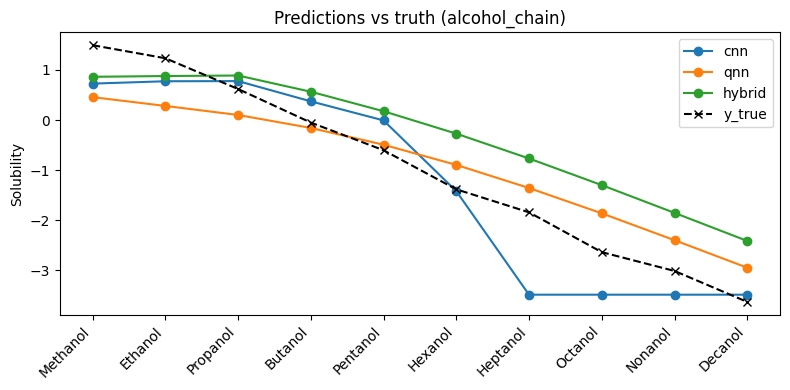

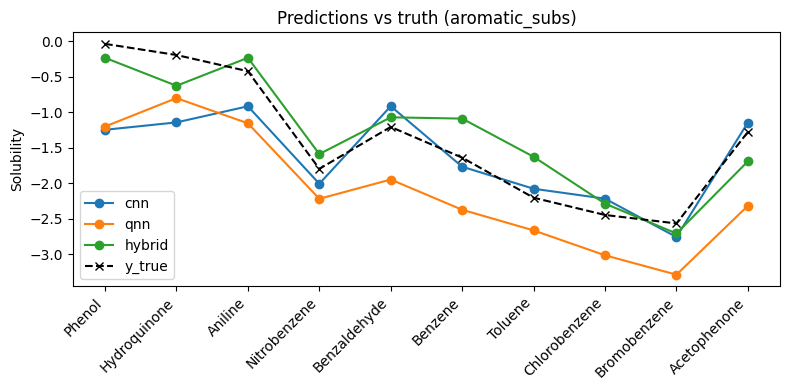

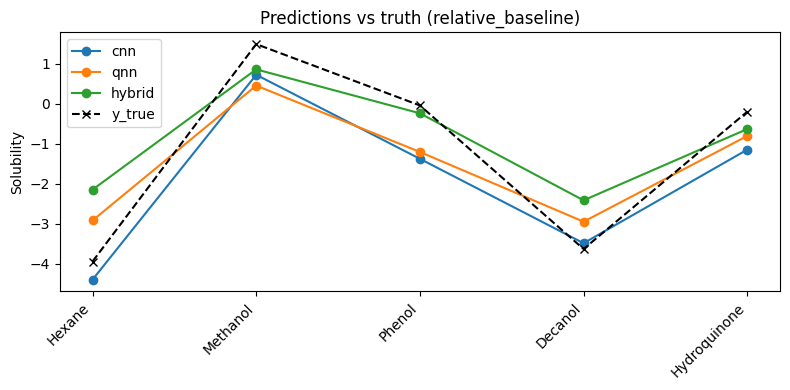

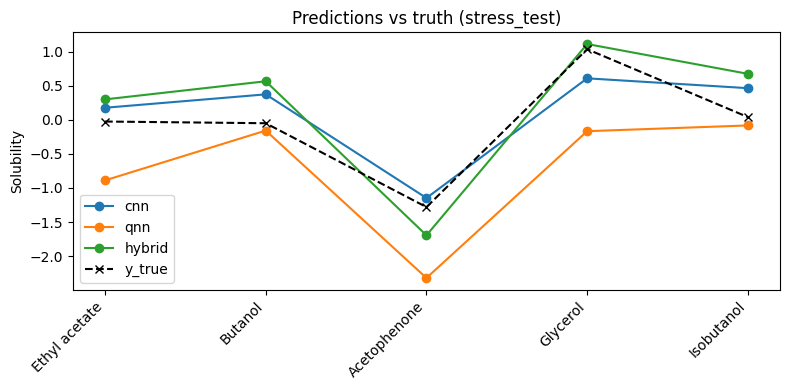

In [28]:
# Quick visuals: per-series line plot (predictions) and bar of abs gaps
import matplotlib.pyplot as plt

for name, df in combined.items():
    plt.figure(figsize=(8, 4))
    for col in ["cnn_y_pred", "qnn_y_pred", "hybrid_y_pred"]:
        plt.plot(df["compound"], df[col], marker="o", label=col.replace("_y_pred", ""))
    if "y_true" in df and not df["y_true"].isna().all():
        plt.plot(df["compound"], df["y_true"], marker="x", linestyle="--", color="black", label="y_true")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Solubility")
    plt.title(f"Predictions vs truth ({name})")
    plt.legend()
    plt.tight_layout()
    plt.show()
